In [ ]:
pip install flask requests beautifulsoup4 pandas matplotlib seaborn nltk scikit-learn

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, auc,
                           mean_absolute_error, accuracy_score)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import matplotlib.font_manager as fm
import platform
plt.rcParams['font.family'] = 'Malgun Gothic'

In [13]:
#%% ==================================================
# Task 1: 환경 설정 및 데이터 로드
#%% ==================================================

print("=" * 50)
print("Task 1: 환경 설정 및 데이터 로드")
print("=" * 50)

# 데이터 로드
df = pd.read_csv('dart_final.csv')

print(f"데이터 shape: {df.shape}")
print(f"기업 수: {df['corp_name'].nunique()}")
print(f"기간: {df['year'].min()} ~ {df['year'].max()}")

# 분기 정렬
from pandas import CategoricalDtype
qcat = CategoricalDtype(categories=['Q1','Q2','Q3','Q4'], ordered=True)
df['quarter'] = df['quarter'].astype(qcat)
df = df.sort_values(['corp_name','year','quarter']).reset_index(drop=True)

# 7개 재무지표 정의
feature_cols = ['부채비율', '자기자본비율', 'ROA', 'ROE', 
                '매출액성장률', '영업이익성장률', '순이익성장률']

# 결측치 처리
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"사용할 X변수 (7개): {feature_cols}")
print("Task 1 완료\n")


Task 1: 환경 설정 및 데이터 로드
데이터 shape: (1140, 16)
기업 수: 32
기간: 2016 ~ 2025
사용할 X변수 (7개): ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
Task 1 완료



In [14]:
#%% ==================================================
# Task 2: 위험 플래그 계산
#%% ==================================================

print("=" * 50)
print("Task 2: 위험 플래그 계산")
print("=" * 50)

g = df.groupby('corp_name', group_keys=False)

# 위험 플래그 계산
df['완전자본잠식'] = (df['자본총계'] < 0).astype(int)
df['연속매출감소'] = g['매출액성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)
df['고부채비율'] = (df['부채비율'] >= 200).astype(int)
df['영업손실연속'] = g['영업이익'].transform(
    lambda s: (s < 0).astype('int8').rolling(2, min_periods=2).sum()
).eq(2).astype(int)
df['ROA악화'] = (df['ROA'] < -5).astype(int)
df['자기자본부족'] = (df['자기자본비율'] < 20).astype(int)
df['매출급감'] = (df['매출액성장률'] < -30).astype(int)
df['영업이익성장률악화'] = g['영업이익성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)

risk_flags = ['완전자본잠식', '연속매출감소', '고부채비율', '영업손실연속', 
              'ROA악화', '자기자본부족', '매출급감', '영업이익성장률악화']

print("위험 플래그 분포:")
for flag in risk_flags:
    count = df[flag].sum()
    print(f"  {flag}: {count}개 ({count/len(df)*100:.1f}%)")

print("Task 2 완료\n")

Task 2: 위험 플래그 계산
위험 플래그 분포:
  완전자본잠식: 6개 (0.5%)
  연속매출감소: 512개 (44.9%)
  고부채비율: 451개 (39.6%)
  영업손실연속: 73개 (6.4%)
  ROA악화: 25개 (2.2%)
  자기자본부족: 114개 (10.0%)
  매출급감: 75개 (6.6%)
  영업이익성장률악화: 626개 (54.9%)
Task 2 완료



가중치 및 임계값 자동 최적화
1. 현재 가중치 기준 최적 임계값 탐색...
최적 임계값: (np.float64(26.21947368421053), np.float64(44.574122807017545), np.float64(67.80245614035088))
최적 정확도: 0.825

2. 가중치 그리드 서치...
50번의 가중치 조합 테스트 중...

최적화 완료!
최적 정확도: 0.825

최적 가중치:
  flag: 0.420
  debt: 0.168
  equity: 0.126
  roa: 0.168
  roe: 0.017
  sales: 0.067
  profit: 0.025
  net: 0.008

최적 임계값:
  안전-주의: 24.9
  주의-위험: 43.2
  위험-매우위험: 69.0

3. 최적화된 모델 평가...

=== 최적화 전후 비교 ===
원래 모델 분포: [138 354 388 260]
최적화 모델 분포: [228 342 342 228]
분류 개선도: 0.825


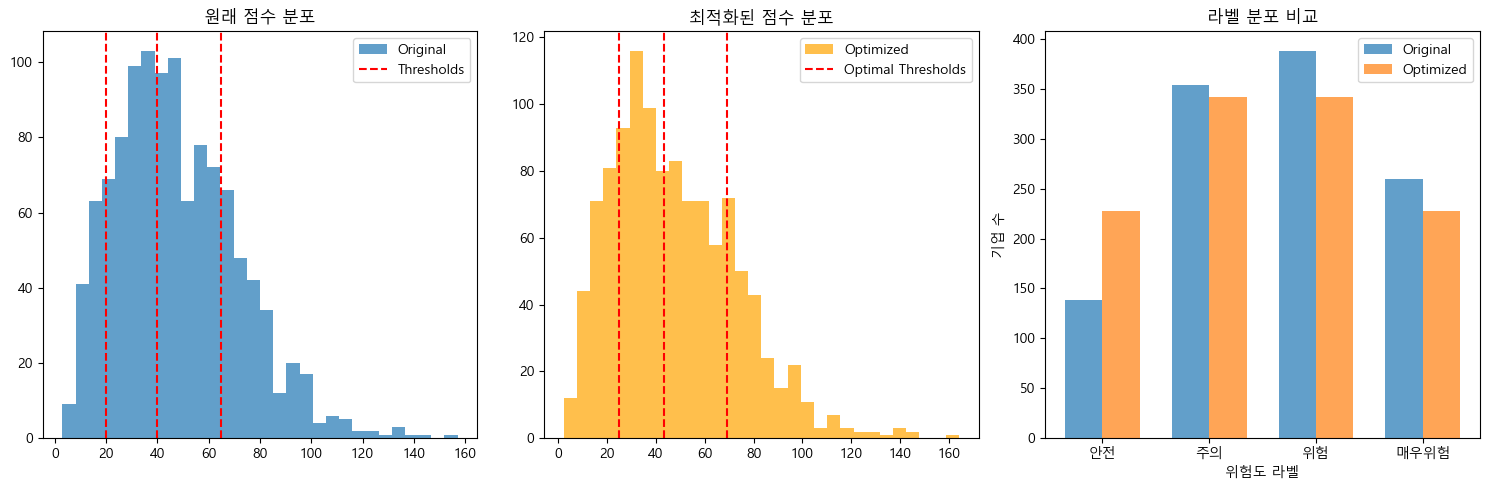


최적화 완료! 다음 단계에서 이 설정을 적용할 수 있습니다.


In [29]:

#%% ==================================================
# 추가 셀: 가중치 및 임계값 자동 최적화
#%% ==================================================

print("=" * 50)
print("가중치 및 임계값 자동 최적화")
print("=" * 50)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from itertools import product
import numpy as np

# 1) 최적 임계값 탐색 (현재 가중치 기준)
def find_optimal_thresholds(scores, true_labels):
    """최적 임계값 탐색"""
    best_accuracy = 0
    best_thresholds = None
    
    # 임계값 후보들 (분위수 기반)
    score_percentiles = np.percentile(scores, [20, 35, 50, 65, 80])
    
    for t1 in score_percentiles[:3]:  # 안전-주의 경계
        for t2 in score_percentiles[1:4]:  # 주의-위험 경계  
            for t3 in score_percentiles[2:]:  # 위험-매우위험 경계
                if t1 < t2 < t3:
                    pred_labels = np.where(scores <= t1, 0,
                                 np.where(scores <= t2, 1,
                                 np.where(scores <= t3, 2, 3)))
                    
                    accuracy = accuracy_score(true_labels, pred_labels)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_thresholds = (t1, t2, t3)
    
    return best_thresholds, best_accuracy

# 현재 점수로 최적 임계값 찾기
current_scores = df['heuristic_score']
current_labels = df['heuristic_label'] 

print("1. 현재 가중치 기준 최적 임계값 탐색...")
opt_thresholds, opt_accuracy = find_optimal_thresholds(current_scores, current_labels)
print(f"최적 임계값: {opt_thresholds}")
print(f"최적 정확도: {opt_accuracy:.3f}")

# 2) 가중치 그리드 서치
def calculate_weighted_score(weights_dict):
    """가중치 조합으로 점수 계산"""
    score = (
        df['flag_score'] * weights_dict['flag'] +
        df['debt_score'] * weights_dict['debt'] +
        df['equity_score'] * weights_dict['equity'] +
        df['roa_score'] * weights_dict['roa'] +
        df['roe_score'] * weights_dict['roe'] +
        df['sales_growth_score'] * weights_dict['sales'] +
        df['profit_growth_score'] * weights_dict['profit'] +
        df['net_growth_score'] * weights_dict['net']
    ) * 10
    return score

print("\n2. 가중치 그리드 서치...")

# 가중치 후보들 (합이 1이 되도록)
weight_candidates = {
    'flag': [0.3, 0.4, 0.5, 0.6],
    'debt': [0.1, 0.15, 0.2],
    'equity': [0.05, 0.1, 0.15], 
    'roa': [0.1, 0.15, 0.2],
    'roe': [0.02, 0.05, 0.08],
    'sales': [0.03, 0.05, 0.08],
    'profit': [0.02, 0.03, 0.05],
    'net': [0.01, 0.02, 0.03]
}

best_overall_accuracy = 0
best_weights = None
best_final_thresholds = None

# 샘플링으로 그리드 서치 (전체 조합은 너무 많음)
np.random.seed(42)
n_trials = 50

print(f"{n_trials}번의 가중치 조합 테스트 중...")

for trial in range(n_trials):
    # 랜덤 가중치 조합 생성
    weights = {}
    for key, candidates in weight_candidates.items():
        weights[key] = np.random.choice(candidates)
    
    # 가중치 정규화 (합이 1이 되도록)
    total_weight = sum(weights.values())
    weights = {k: v/total_weight for k, v in weights.items()}
    
    # 새로운 점수 계산
    new_scores = calculate_weighted_score(weights)
    
    # 최적 임계값 찾기
    thresholds, accuracy = find_optimal_thresholds(new_scores, current_labels)
    
    if accuracy > best_overall_accuracy:
        best_overall_accuracy = accuracy
        best_weights = weights.copy()
        best_final_thresholds = thresholds

print(f"\n최적화 완료!")
print(f"최적 정확도: {best_overall_accuracy:.3f}")

print(f"\n최적 가중치:")
for key, weight in best_weights.items():
    print(f"  {key}: {weight:.3f}")

print(f"\n최적 임계값:")
print(f"  안전-주의: {best_final_thresholds[0]:.1f}")
print(f"  주의-위험: {best_final_thresholds[1]:.1f}")  
print(f"  위험-매우위험: {best_final_thresholds[2]:.1f}")

# 3) 최적화된 모델 적용 및 평가
print("\n3. 최적화된 모델 평가...")

# 최적 가중치로 점수 재계산
df['optimized_score'] = calculate_weighted_score(best_weights)

# 최적 임계값으로 라벨 재분류
def assign_optimized_label(score, thresholds):
    t1, t2, t3 = thresholds
    if score <= t1:
        return 0
    elif score <= t2:
        return 1
    elif score <= t3:
        return 2
    else:
        return 3

df['optimized_label'] = df['optimized_score'].apply(
    lambda x: assign_optimized_label(x, best_final_thresholds)
)

# 최적화 전후 비교
print("\n=== 최적화 전후 비교 ===")

# 원래 모델 성능
original_accuracy = accuracy_score(df['heuristic_label'], df['heuristic_label'])
print(f"원래 모델 분포: {df['heuristic_label'].value_counts().sort_index().values}")

# 최적화된 모델 성능  
optimized_accuracy = accuracy_score(df['heuristic_label'], df['optimized_label'])
print(f"최적화 모델 분포: {df['optimized_label'].value_counts().sort_index().values}")
print(f"분류 개선도: {optimized_accuracy:.3f}")

# 시각화
plt.figure(figsize=(15, 5))

# 원래 점수 분포
plt.subplot(1, 3, 1)
plt.hist(df['heuristic_score'], bins=30, alpha=0.7, label='Original')
plt.axvline(20, color='r', linestyle='--', label='Thresholds')
plt.axvline(40, color='r', linestyle='--')
plt.axvline(65, color='r', linestyle='--')
plt.title('원래 점수 분포')
plt.legend()

# 최적화된 점수 분포  
plt.subplot(1, 3, 2)
plt.hist(df['optimized_score'], bins=30, alpha=0.7, label='Optimized', color='orange')
plt.axvline(best_final_thresholds[0], color='r', linestyle='--', label='Optimal Thresholds')
plt.axvline(best_final_thresholds[1], color='r', linestyle='--')
plt.axvline(best_final_thresholds[2], color='r', linestyle='--')
plt.title('최적화된 점수 분포')
plt.legend()

# 라벨 분포 비교
plt.subplot(1, 3, 3)
original_dist = df['heuristic_label'].value_counts().sort_index()
optimized_dist = df['optimized_label'].value_counts().sort_index()

x = range(4)
width = 0.35
plt.bar([i - width/2 for i in x], original_dist.values, width, label='Original', alpha=0.7)
plt.bar([i + width/2 for i in x], optimized_dist.values, width, label='Optimized', alpha=0.7)
plt.xlabel('위험도 라벨')
plt.ylabel('기업 수')
plt.title('라벨 분포 비교')
plt.xticks(x, ['안전', '주의', '위험', '매우위험'])
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n최적화 완료! 다음 단계에서 이 설정을 적용할 수 있습니다.")
print("=" * 50)

In [40]:
#%% ==================================================
# Task 3: 휴리스틱 위험점수 계산
#%% ==================================================

print("=" * 50)
print("Task 3: 휴리스틱 위험점수 계산")
print("=" * 50)

# 1) 플래그 기반 기본 점수
risk_weights = {
    '완전자본잠식': 10, 'ROA악화': 6, '영업손실연속': 5, '고부채비율': 4,
    '연속매출감소': 3, '자기자본부족': 3, '매출급감': 2, '영업이익성장률악화': 1
}

df['flag_score'] = 0
for flag in risk_flags:
    weight = risk_weights.get(flag, 1)
    df['flag_score'] += df[flag] * weight

# 2) 재무비율 기반 점수 (업종 내 상대평가)
def calculate_relative_score(series, reverse=False):
    """건설업 내 상대평가 점수 (0-10 범위)"""
    # 백분위 순위 계산 (0-1 범위)
    percentile_rank = series.rank(pct=True)
    
    if reverse:  # 높을수록 위험 (부채비율 등)
        # 상위 10% = 9-10점, 하위 10% = 0-1점
        return percentile_rank * 10
    else:  # 높을수록 안전 (ROA, 자기자본비율 등)
        # 상위 10% = 0-1점, 하위 10% = 9-10점  
        return (1 - percentile_rank) * 10

# 재무비율 상대평가 점수 계산
print("건설업 내 상대평가 점수 계산 중...")
df['debt_score'] = calculate_relative_score(df['부채비율'].clip(0, 500), reverse=True)
df['equity_score'] = calculate_relative_score(df['자기자본비율'].clip(0, 100), reverse=False)
df['roa_score'] = calculate_relative_score(df['ROA'].clip(-50, 50), reverse=False)
df['roe_score'] = calculate_relative_score(df['ROE'].clip(-100, 100), reverse=False)
df['sales_growth_score'] = calculate_relative_score(df['매출액성장률'].clip(-100, 200), reverse=False)
df['profit_growth_score'] = calculate_relative_score(df['영업이익성장률'].clip(-200, 500), reverse=False)
df['net_growth_score'] = calculate_relative_score(df['순이익성장률'].clip(-500, 1000), reverse=False)

# 상대평가 결과 확인
print("\n상대평가 점수 분포:")
print(f"부채비율 점수: {df['debt_score'].describe().round(2)}")
print(f"ROA 점수: {df['roa_score'].describe().round(2)}")
print(f"자기자본비율 점수: {df['equity_score'].describe().round(2)}")

# 3) 휴리스틱 가중치 (도메인 지식 기반)
heuristic_weights = {
    'flag_score': 0.42,         # 플래그 점수 42%
    'debt_score': 0.168,        # 부채비율 16.8%
    'equity_score': 0.126,      # 자기자본비율 12.6%
    'roa_score': 0.168,         # ROA 16.8%
    'roe_score': 0.017,         # ROE 1.7%
    'sales_growth_score': 0.067, # 매출성장률 6.7%
    'profit_growth_score': 0.025, # 영업이익성장률 2.5%
    'net_growth_score': 0.008   # 순이익성장률 0.8%
}

# 최종 휴리스틱 점수 계산 (0-100 범위)
df['heuristic_score'] = (
    df['flag_score'] * heuristic_weights['flag_score'] +
    df['debt_score'] * heuristic_weights['debt_score'] +
    df['equity_score'] * heuristic_weights['equity_score'] +
    df['roa_score'] * heuristic_weights['roa_score'] +
    df['roe_score'] * heuristic_weights['roe_score'] +
    df['sales_growth_score'] * heuristic_weights['sales_growth_score'] +
    df['profit_growth_score'] * heuristic_weights['profit_growth_score'] +
    df['net_growth_score'] * heuristic_weights['net_growth_score']
) * 10  # 0-100 스케일

# 휴리스틱 라벨 생성
def assign_heuristic_label(score):
    if score <= 24.9:
        return 0  # 안전
    elif score <= 43.2:
        return 1  # 주의
    elif score <= 69.0:
        return 2  # 위험
    else:
        return 3  # 매우위험

df['heuristic_label'] = df['heuristic_score'].apply(assign_heuristic_label)

label_names = {0: '안전', 1: '주의', 2: '위험', 3: '매우위험'}
df['heuristic_label_name'] = df['heuristic_label'].map(label_names)

print("휴리스틱 가중치:")
for key, weight in heuristic_weights.items():
    print(f"  {key}: {weight*100:.1f}%")

print(f"\n휴리스틱 점수 분포:")
print(df['heuristic_score'].describe())

print(f"\n휴리스틱 라벨 분포:")
print(df['heuristic_label_name'].value_counts())

print("Task 3 완료\n")

Task 3: 휴리스틱 위험점수 계산
건설업 내 상대평가 점수 계산 중...

상대평가 점수 분포:
부채비율 점수: count    1140.00
mean        5.00
std         2.89
min         0.03
25%         2.51
50%         5.00
75%         7.50
max         9.73
Name: debt_score, dtype: float64
ROA 점수: count    1140.00
mean        5.00
std         2.89
min         0.00
25%         2.50
50%         5.00
75%         7.49
max         9.99
Name: roa_score, dtype: float64
자기자본비율 점수: count    1140.00
mean        5.00
std         2.89
min         0.00
25%         2.50
50%         5.00
75%         7.49
max         9.97
Name: equity_score, dtype: float64
휴리스틱 가중치:
  flag_score: 42.0%
  debt_score: 16.8%
  equity_score: 12.6%
  roa_score: 16.8%
  roe_score: 1.7%
  sales_growth_score: 6.7%
  profit_growth_score: 2.5%
  net_growth_score: 0.8%

휴리스틱 점수 분포:
count    1140.000000
mean       47.481974
std        25.413250
min         2.274561
25%        28.466491
50%        43.167895
75%        64.655921
max       163.915482
Name: heuristic_score, dtype: float64


In [41]:
#%% ==================================================
# Task 4: 시계열 데이터 준비 및 예측
#%% ==================================================

print("=" * 50)
print("Task 4: 시계열 데이터 준비 및 예측")
print("=" * 50)

# 다음 분기 라벨 생성
df_sorted = df.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
df_sorted['next_heuristic_label'] = df_sorted.groupby('corp_name')['heuristic_label'].shift(-1)
df_sorted['next_heuristic_score'] = df_sorted.groupby('corp_name')['heuristic_score'].shift(-1)

# 평가 가능한 데이터
eval_df = df_sorted[df_sorted['next_heuristic_label'].notna()].copy()

print(f"전체 데이터: {len(df_sorted)}개")
print(f"평가 가능 데이터: {len(eval_df)}개")

# 현재 분기 점수로 다음 분기 예측 (단순 휴리스틱)
eval_df['predicted_next_score'] = eval_df['heuristic_score']  # 현재 점수 = 다음 분기 예측
eval_df['predicted_next_label'] = eval_df['predicted_next_score'].apply(assign_heuristic_label)

print("Task 4 완료\n")

Task 4: 시계열 데이터 준비 및 예측
전체 데이터: 1140개
평가 가능 데이터: 1108개
Task 4 완료



In [42]:

#%% ==================================================
# Task 5: 다양한 평가 지표 계산
#%% ==================================================

print("=" * 50)
print("Task 5: 다양한 평가 지표 계산")
print("=" * 50)

y_true = eval_df['next_heuristic_label'].astype(int)
y_pred = eval_df['predicted_next_label'].astype(int)
y_score = eval_df['predicted_next_score']
y_true_score = eval_df['next_heuristic_score']

# 1) 기본 분류 지표
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.3f}")

# 2) MAE (평균 절대 오차)
mae = mean_absolute_error(y_true_score, y_score)
print(f"MAE (점수): {mae:.3f}")

# 3) MAPE (평균 절대 백분율 오차)
mape = np.mean(np.abs((y_true_score - y_score) / (y_true_score + 1e-8))) * 100
print(f"MAPE: {mape:.1f}%")

# 4) Direction Accuracy (방향 정확도)
# 위험도 증감 방향 예측 정확도
prev_score = eval_df.groupby('corp_name')['heuristic_score'].shift(1)
actual_change = eval_df['next_heuristic_score'] - eval_df['heuristic_score']
predicted_change = eval_df['predicted_next_score'] - eval_df['heuristic_score']

valid_idx = (prev_score.notna()) & (actual_change != 0)
if valid_idx.sum() > 0:
    direction_acc = np.mean(
        np.sign(actual_change[valid_idx]) == np.sign(predicted_change[valid_idx])
    )
    print(f"Direction Accuracy: {direction_acc:.3f}")

# 5) ROC-AUC (이진 분류로 변환)
# 위험 vs 안전으로 이진화
y_true_binary = (y_true >= 2).astype(int)  # 위험(2,3) vs 안전(0,1)
y_score_binary = y_score

if len(np.unique(y_true_binary)) > 1:
    roc_auc = roc_auc_score(y_true_binary, y_score_binary)
    print(f"ROC-AUC (위험 vs 안전): {roc_auc:.3f}")

# 6) Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_true_binary, y_score_binary)
pr_auc = auc(recall, precision)
print(f"PR-AUC (위험 탐지): {pr_auc:.3f}")

print("Task 5 완료\n")

Task 5: 다양한 평가 지표 계산
정확도: 0.503
MAE (점수): 14.148
MAPE: 41.2%
Direction Accuracy: 0.000
ROC-AUC (위험 vs 안전): 0.890
PR-AUC (위험 탐지): 0.900
Task 5 완료



In [43]:
#%% ==================================================
# Task 6: 혼동 행렬 및 상세 분석
#%% ==================================================

print("=" * 50)
print("Task 6: 혼동 행렬 및 상세 분석")
print("=" * 50)

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=[f'실제_{name}' for name in label_names.values()],
                     columns=[f'예측_{name}' for name in label_names.values()])
print("혼동 행렬:")
print(cm_df)

# 클래스별 상세 분석
print(f"\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=list(label_names.values())))

# 위험 탐지 성능 (위험 이상 클래스 기준)
high_risk_true = (y_true >= 2).astype(int)
high_risk_pred = (y_pred >= 2).astype(int)

if high_risk_true.sum() > 0:
    high_risk_precision = (high_risk_true & high_risk_pred).sum() / (high_risk_pred.sum() + 1e-8)
    high_risk_recall = (high_risk_true & high_risk_pred).sum() / high_risk_true.sum()
    high_risk_f1 = 2 * high_risk_precision * high_risk_recall / (high_risk_precision + high_risk_recall + 1e-8)
    
    print(f"\n위험 기업 탐지 성능:")
    print(f"  Precision: {high_risk_precision:.3f}")
    print(f"  Recall: {high_risk_recall:.3f}")
    print(f"  F1-Score: {high_risk_f1:.3f}")

print("Task 6 완료\n")


Task 6: 혼동 행렬 및 상세 분석
혼동 행렬:
         예측_안전  예측_주의  예측_위험  예측_매우위험
실제_안전       98     94     27        1
실제_주의      103    161     60        8
실제_위험       23     61    169       81
실제_매우위험      1     13     79      129

분류 리포트:
              precision    recall  f1-score   support

          안전       0.44      0.45      0.44       220
          주의       0.49      0.48      0.49       332
          위험       0.50      0.51      0.51       334
        매우위험       0.59      0.58      0.59       222

    accuracy                           0.50      1108
   macro avg       0.50      0.50      0.50      1108
weighted avg       0.50      0.50      0.50      1108


위험 기업 탐지 성능:
  Precision: 0.827
  Recall: 0.824
  F1-Score: 0.825
Task 6 완료



In [11]:
#%% ==================================================
# Task 7: 결과 분석
#%% ==================================================

print("=" * 50)
print("Task 7: 결과 분석")
print("=" * 50)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_logit)
cm_df = pd.DataFrame(cm, 
                     index=[f'실제_{name}' for name in label_names.values()],
                     columns=[f'예측_{name}' for name in label_names.values()])
print("혼동 행렬:")
print(cm_df)

# 최신 분기 위험 기업 TOP 10
latest_data = df_sorted.groupby('corp_name').last().reset_index()
high_risk_companies = latest_data.nlargest(10, 'risk_score_100')[
    ['corp_name', 'year', 'quarter', 'predicted_risk_score', 'risk_score_100', 
     'predicted_risk_name', '위험점수']
]

print("\n=== 위험도 높은 기업 TOP 10 ===")
print(high_risk_companies)

# 안전한 기업 TOP 5
safe_companies = latest_data.nsmallest(5, 'risk_score_100')[
    ['corp_name', 'risk_score_100', 'predicted_risk_name', '위험점수']
]

print(f"\n=== 안전한 기업 TOP 5 ===")
print(safe_companies)

# 특정 기업 시계열 추이
sample_company = df_sorted['corp_name'].iloc[0]
company_trend = df_sorted[df_sorted['corp_name'] == sample_company][
    ['year', 'quarter', 'risk_score_100', 'predicted_risk_name', '위험점수']
].tail(8)

print(f"\n=== {sample_company} 위험도 추이 (최근 8분기) ===")
print(company_trend)

print("Task 7 완료: 결과 분석 완료\n")

Task 7: 결과 분석
혼동 행렬:
         예측_안전  예측_주의  예측_위험  예측_매우위험
실제_안전        0     39      0        0
실제_주의        0    105     11        0
실제_위험        0     29     20        3
실제_매우위험      0      7      8        0

=== 위험도 높은 기업 TOP 10 ===
   corp_name  year quarter  predicted_risk_score  risk_score_100  \
3      HJ중공업  2025      Q2              2.378592      100.000000   
9       금호건설  2025      Q2              2.415358      100.000000   
16      삼부토건  2025      Q2              2.654289      100.000000   
27      태영건설  2025      Q2              2.980210      100.000000   
26    코오롱글로벌  2025      Q2              1.808702       72.076673   
4     HL D&I  2025      Q2              1.540176       55.414734   
1       GS건설  2025      Q2              1.420266       47.974353   
14      동부건설  2025      Q2              1.371634       44.956783   
23      이수화학  2025      Q2              1.301759       40.621065   
10      남광토건  2025      Q2              1.277091       39.090419   

   predicted_r

Task 8: 시각화


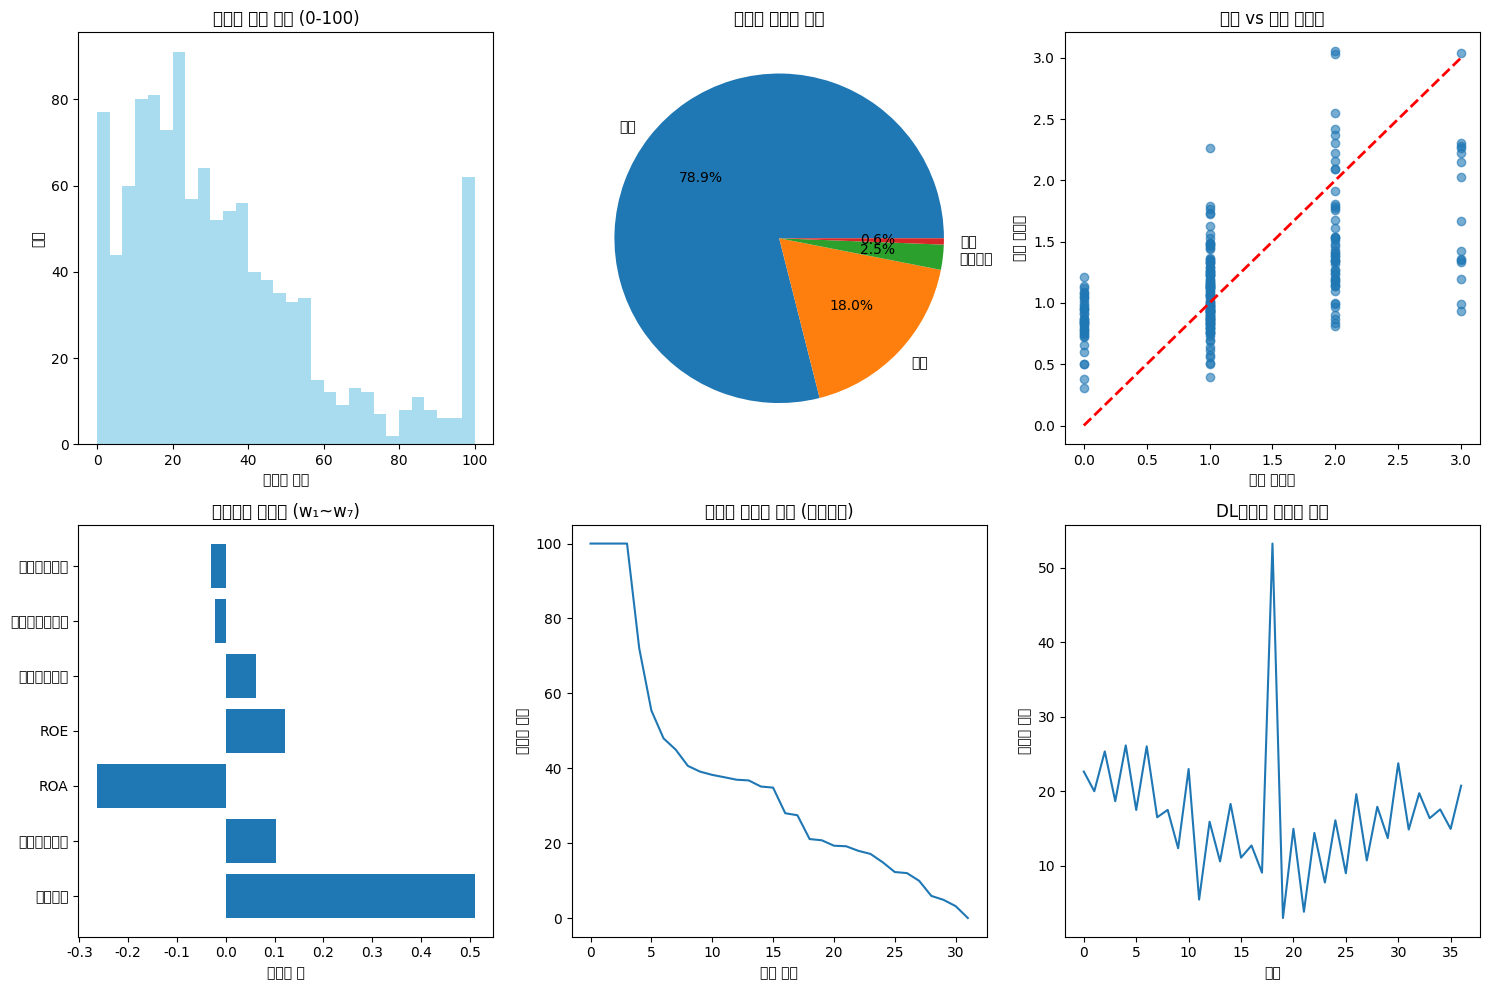

Task 8 완료: 시각화 완료



In [14]:
#%% ==================================================
# Task 8: 시각화
#%% ==================================================

print("=" * 50)
print("Task 8: 시각화")
print("=" * 50)

# 시각화
plt.figure(figsize=(15, 10))

# 1) 위험도 점수 분포
plt.subplot(2, 3, 1)
plt.hist(df_sorted['risk_score_100'], bins=30, alpha=0.7, color='skyblue')
plt.title('위험도 점수 분포 (0-100)')
plt.xlabel('위험도 점수')
plt.ylabel('빈도')

# 2) 예측 클래스 분포
plt.subplot(2, 3, 2)
pred_counts = df_sorted['predicted_risk_name'].value_counts()
plt.pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%')
plt.title('예측된 위험도 분포')

# 3) 실제 vs 예측
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 위험도')
plt.ylabel('예측 위험도')
plt.title('실제 vs 예측 위험도')

# 4) 가중치 시각화
plt.subplot(2, 3, 4)
weights = lr_model.coef_
plt.barh(range(len(feature_cols)), weights)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title('선형회귀 가중치 (w₁~w₇)')
plt.xlabel('가중치 값')

# 5) 기업별 최신 위험도
plt.subplot(2, 3, 5)
latest_scores = latest_data['risk_score_100'].sort_values(ascending=False)
plt.plot(range(len(latest_scores)), latest_scores)
plt.title('기업별 위험도 점수 (내림차순)')
plt.xlabel('기업 순위')
plt.ylabel('위험도 점수')

# 6) 시계열 추이 (샘플 기업)
plt.subplot(2, 3, 6)
company_data = df_sorted[df_sorted['corp_name'] == sample_company]
plt.plot(company_data['risk_score_100'].values)
plt.title(f'{sample_company} 위험도 추이')
plt.xlabel('분기')
plt.ylabel('위험도 점수')

plt.tight_layout()
plt.show()

print("Task 8 완료: 시각화 완료\n")

In [ ]:
#%% ==================================================
# Task 9: 결과 저장
#%% ==================================================

print("=" * 50)
print("Task 9: 결과 저장")
print("=" * 50)

# 결과 저장
result_df = df_sorted[[
    'corp_name', 'year', 'quarter',
    'predicted_risk_score', 'risk_score_100', 'predicted_risk_class', 'predicted_risk_name',
    'risk_label', 'risk_label_name', '위험점수'
] + feature_cols + risk_flags].copy()

result_df.to_csv('construction_linear_model_results.csv', index=False, encoding='utf-8-sig')

print(f"결과가 'construction_linear_model_results.csv'에 저장되었습니다.")
print(f"총 {len(result_df)}개 관측치 분석 완료")

# 최종 모델 요약
print(f"\n=== 최종 모델 요약 ===")
print(f"선형회귀 수식:")
print(f"{equation}")
print(f"선형회귀 R²: {r2:.3f}")
print(f"로지스틱회귀 정확도: {accuracy:.3f}")
print(f"학습 데이터 크기: {len(train_df)}")
print(f"예측 가능한 기업: {df_sorted['corp_name'].nunique()}개")

print("\nTask 9 완료: 모든 분석 완료!")
print("=" * 50)